# Exploratory Data Analysis
---

Nhiệm vụ của phần này là khám phá dữ liệu tập dataset dùng để huấn luyện

## IMPORT

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import linregress

## ĐỌC DỮ LIỆU

In [2]:
# Google Colab
# url = "https://raw.githubusercontent.com/uyen312/Project_PTDLTM/main/Data/dataset.csv"
# df = pd.read_csv(url)

# VSCode
df = pd.read_csv("../Data/dataset.csv")

In [3]:
df.head(5)

,id,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,...,0,0,0,0,0,0,0,0,0,I
1,1,1999-01-15,313300,NaN,26,nochg,2025,47.6531,-122.1996,74,...,0,0,0,0,0,1,0,0,0,Q
2,2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,...,0,0,0,0,0,0,0,0,0,K
3,3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,...,0,0,0,0,0,0,0,0,0,G
4,4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,...,0,0,0,0,0,0,0,0,0,P


## EDA

### Mối tương quan giữa các biến

Tương quan giữa các biến numeric

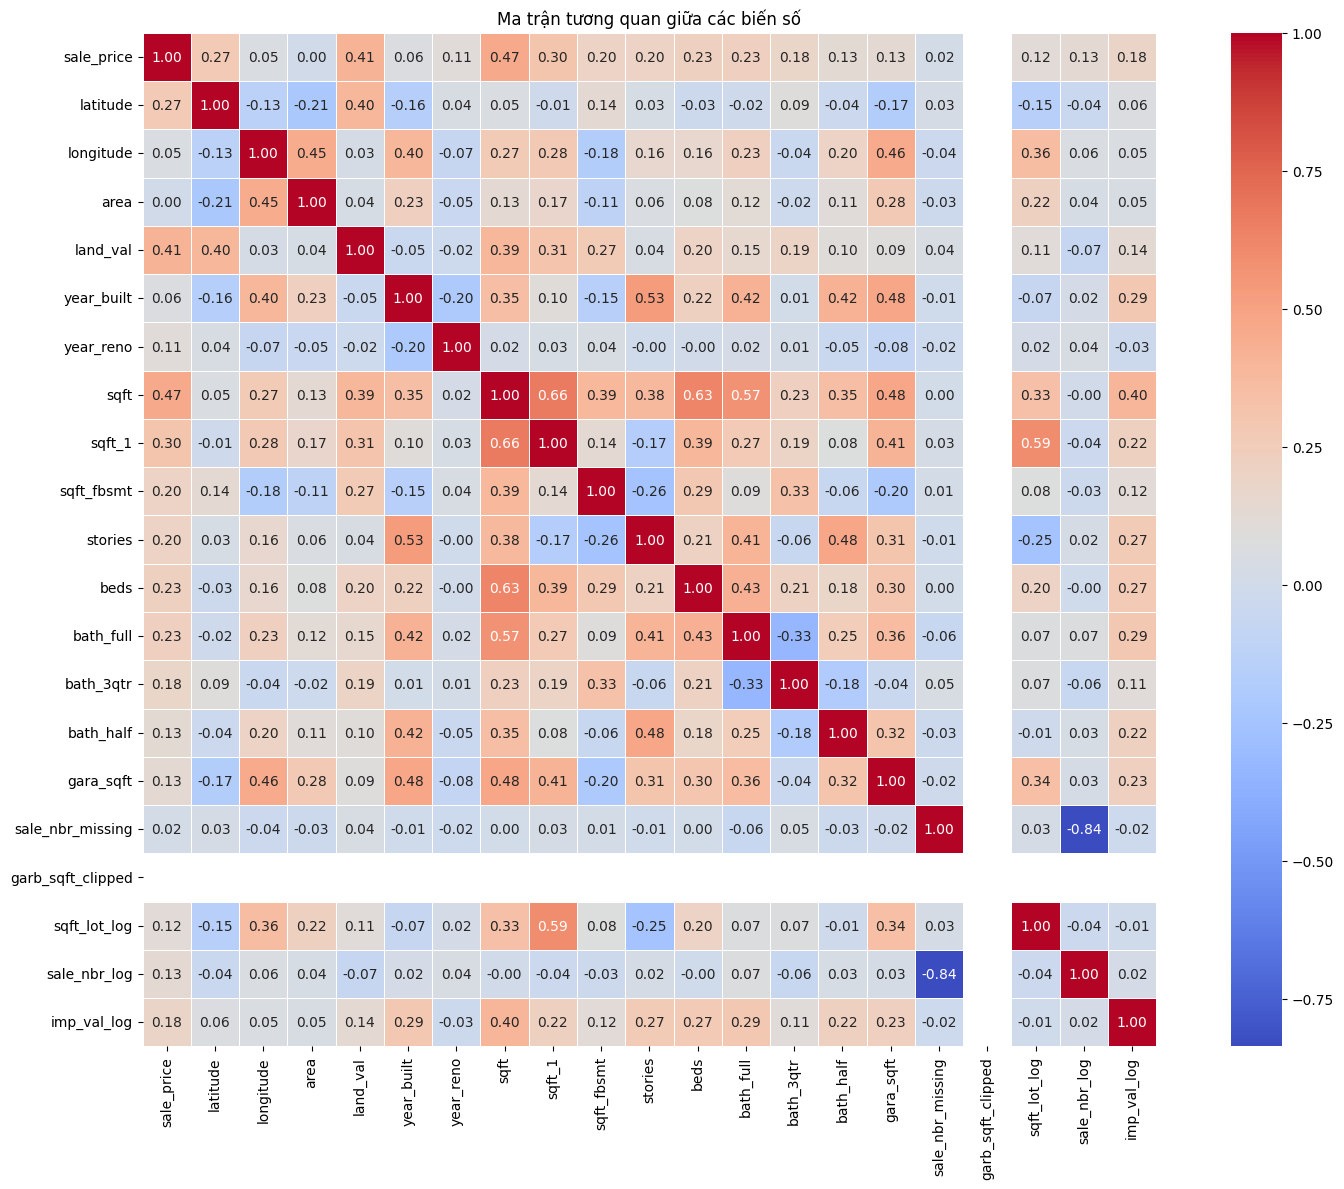

In [35]:
# Lọc ra các cột số
num_df = df.select_dtypes(include=['number'])

# Tính ma trận tương quan
corr_matrix = num_df.corr(numeric_only=True)

# Vẽ heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)
plt.title("Ma trận tương quan giữa các biến số")
plt.tight_layout()
plt.show()

Lọc ra các cặp có tương quan cao (hệ số tương quan > |0.7|)

In [36]:
# Lấy cặp tương quan cao
threshold = 0.7
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

# Lọc ra các cặp có tương quan cao nhưng khác nhau (không phải chính nó)
high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1))]

# Xóa trùng (A,B) và (B,A)
high_corr = high_corr.groupby(frozenset).first()

print("Các cặp cột có tương quan cao:")
print(high_corr)

Các cặp cột có tương quan cao:
(sale_nbr_log, sale_nbr_missing)   -0.836398
dtype: float64


**Nhận xét**

- (imp_val, sqft) ~ 0.78: Diện tích sử dụng càng lớn thì giá trị xây dựng càng cao, vì nhà lớn thường có giá trị xây dựng cao hơn. Đây là mối quan hệ hợp lý trong bất động sản.

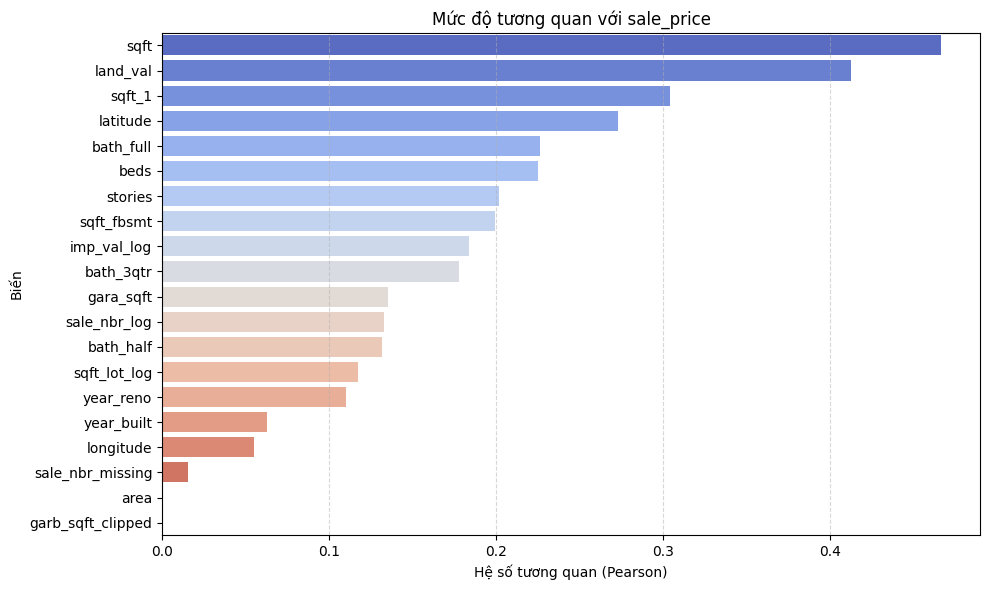

In [37]:
# Tính tương quan với biến mục tiêu sale_price
target_corr = num_df.corr(numeric_only=True)['sale_price'].drop('sale_price')

# Sắp xếp theo độ tương quan
target_corr_sorted = target_corr.sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr_sorted.values, y=target_corr_sorted.index, hue=target_corr_sorted.index, palette='coolwarm')
plt.title("Mức độ tương quan với sale_price")
plt.xlabel("Hệ số tương quan (Pearson)")
plt.ylabel("Biến")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Nhận xét**

- Các biến có tương quan dương mạnh nhất với `sale_price` là: `sqft`, `land_val`, `sqft_1`, `latitude`,... Đây đều là các đặc trưng về diện tích, giá trị đất và vị trí, điều này hoàn toàn hợp lý vì nhà càng rộng, chất lượng càng cao, vị trí càng đẹp thì giá càng cao.

- Các biến về tiện nghi và số phòng tắm, phòng ngủ cũng có tương quan dương, phản ánh đúng thực tế thị trường.

- Một số biến gần như không tương quan với `sale_price` như `area` và `garrb_sqrt_clipped` cho thấy các biến này ít ảnh hưởng và gần như không ảnh hưởng rõ rệt đến giá bán.

Mức độ phụ thuộc (Mutual Information) giữa các biến category và cột mục tiêu

Mức độ phụ thuộc (Mutual Information):


subdivision         0.420576
sale_date           0.301665
grade               0.182774
zoning              0.160536
submarket           0.148345
city                0.132110
join_status         0.089910
fbsmt_grade         0.056054
view_territorial    0.025602
condition           0.019220
view_lakewash       0.014824
present_use         0.011563
view_olympics       0.008817
view_sound          0.008356
wfnt                0.006662
view_cascades       0.005794
view_lakesamm       0.004769
view_skyline        0.004588
greenbelt           0.003734
noise_traffic       0.002797
view_other          0.002149
golf                0.001264
view_otherwater     0.001101
view_rainier        0.000946
dtype: float64

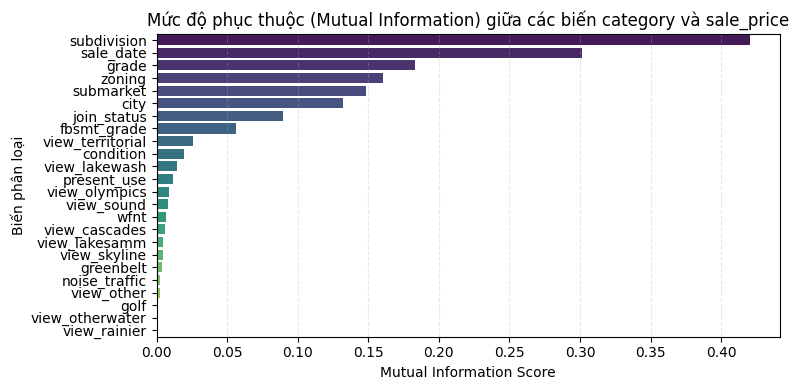

In [38]:
def mutual_info_categorical(df, categorical_columns, target_col='sale_price'):
    encoded_df = pd.DataFrame()
    
    # Mã hóa tất cả các biến phân loại
    for col in categorical_columns:
        le = LabelEncoder()
        try:
            encoded_df[col] = le.fit_transform(df[col].astype(str))
        except:
            continue

    # Tính mutual information
    mi_scores = mutual_info_regression(encoded_df, df[target_col], discrete_features=True)
    mi_series = pd.Series(mi_scores, index=encoded_df.columns).sort_values(ascending=False)

    # In kết quả
    print("Mức độ phụ thuộc (Mutual Information):")
    display(mi_series)

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 4))
    sns.barplot(x=mi_series.values, y=mi_series.index, hue=mi_series.index, palette='viridis')
    plt.title(f'Mức độ phục thuộc (Mutual Information) giữa các biến category và {target_col}')
    plt.xlabel("Mutual Information Score")
    plt.ylabel("Biến phân loại")
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
mutual_info_categorical(df, categorical_columns, target_col='sale_price')

**Nhận xét**

- `subdivision` có mức độ phụ thuộc cao nhất với `sale_price`, đạt hơn 0.4 cho thấy vị trí chi tiết (tiểu khu) là yếu tố rất mạnh ảnh hưởng đến giá nhà, có thể phản ánh chất lượng khu dân cư, tiệc ích, uy tín khu vực,...

- `sale_date` cũng có tương quan mạnh, điều này hợp lý vì giá nhà biến động mạnh theo thời gian (do xu hướng thị trường, lạm phát,...)

- Các yếu tố kỹ thuật như: `grade`, `zoning`, `submarket`, `city`,... đều có mức ảnh hưởng đáng kể đến giá bán, đây là những yếu tố cơ bản trong phân khúc và vùng địa lý.

- Các biến về tiện ích như view, golf, greenbelt đều có Mutual Information gần bằng 0 cho thấy các biến này có phân phối rất lệch (phần lớn giá trị là 0) khiến cho mô hình khó học được gì từ các cột này.

### Dùng t-SNE để quan sát cấu trúc dữ liệu

Do dữ liệu chứa nhiều đặc trưng số với mối quan hệ phi tuyến, nhóm áp dụng t-SNE để giảm chiều dữ liệu và trực quan hóa phân bố mẫu. Điều này giúp phát hiện các cụm tiềm năng, cấu trúc phức tạp và các điểm bất thường có thể ảnh hưởng đến mô hình hồi quy.

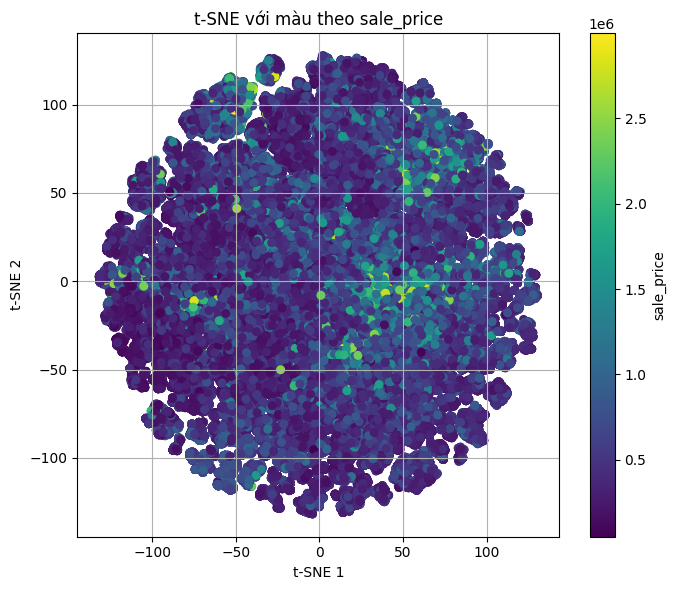

In [39]:
# Chuẩn hóa dữ liệu số
X_num = df.select_dtypes(include='number').drop(columns=['sale_price'])
X_scaled = StandardScaler().fit_transform(X_num)

# Áp dụng t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Vẽ biểu đồ t-SNE
plt.figure(figsize=(7, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['sale_price'], cmap='viridis', s=30)
plt.colorbar(label='sale_price')
plt.title("t-SNE với màu theo sale_price")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

**Nhận xét**

- Đa số các điểm có màu tối, chỉ một số ít điểm có màu sáng rải rác cho thấy phần lớn nhà có giá vừa phải, chỉ có một số ít nhà giá rất cao.

- Các điểm giá cao không tập trung thành một cụm mà phân bố rải rác chứng tỏ các căn nhà đắt tiền không nhất thiết phải giống nhau hoàn toàn về đặc trưng, chúng có thể nằm ở nhiều khu vực khác nhau trong không gian đặc trưng.

- Không xuất hiện các cụm (cluster) rõ ràng về giá bán, tức là giá nhà không hoàn toàn bị chi phối bởi một vài nhóm đặc trưng cụ thể mà có thể chịu ảnh hưởng bởi nhiều yếu tố đa dạng.

### Đặt câu hỏi

**Câu hỏi 1:** Giá nhà có tăng theo thời gian đồng đều ở tất cả các khu vực không? Hay chỉ một số khu vực tăng mạnh?

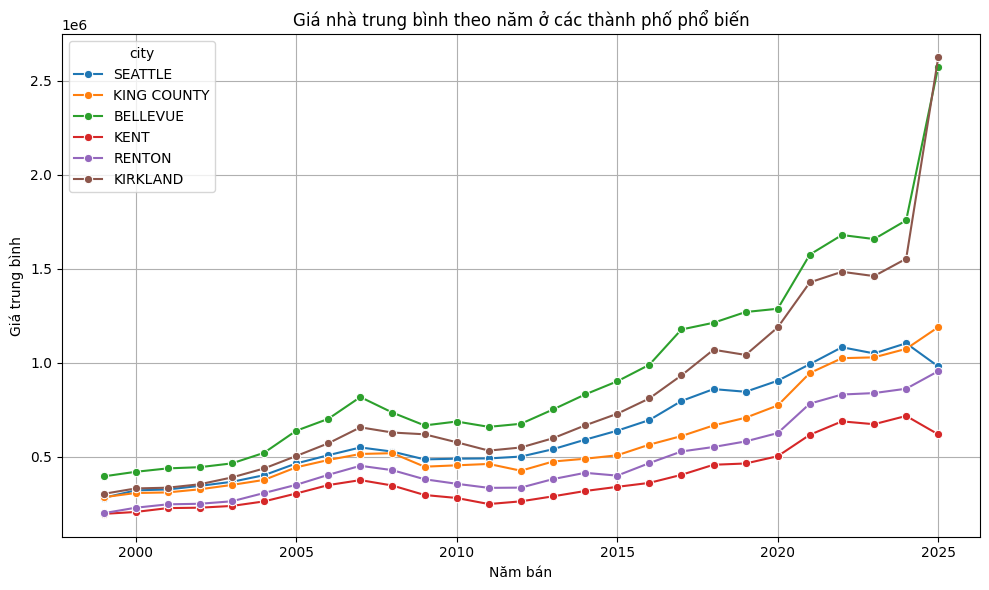

In [40]:
# Bước 1: Tạo biến sale_year
df['sale_year'] = pd.to_datetime(df['sale_date'], errors='coerce').dt.year

# Bước 2: Chọn năm bán hợp lệ (nếu muốn chỉ lấy từ 2000 trở đi)
valid_years = df['sale_year'].dropna().unique()
valid_years = sorted([y for y in valid_years])  # tuỳ chọn

# Bước 3: Đếm số năm có dữ liệu của mỗi city
year_count_per_city = df.groupby('city', observed=False)['sale_year'].nunique()

# Bước 4: Giữ lại những city có đủ tất cả các năm
cities_full_year = year_count_per_city[year_count_per_city >= len(valid_years)].index.tolist()

# Bước 5: Trong số đó, lấy top 6 thành phố nhiều giao dịch nhất
top_cities = df[df['city'].isin(cities_full_year)]['city'].value_counts().head(6).index.tolist()

# Bước 6: Lọc lại dữ liệu
df_city = df[df['city'].isin(top_cities)].copy()

# Nhóm theo city và sale_year, tính giá trung bình
grouped_city = df_city.groupby(['city', 'sale_year'], observed=False)['sale_price'].mean().reset_index()

# Vẽ biểu đồ lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_city, x='sale_year', y='sale_price', hue='city',
             hue_order=top_cities, marker='o')
plt.title("Giá nhà trung bình theo năm ở các thành phố phổ biến")
plt.xlabel("Năm bán")
plt.ylabel("Giá trung bình")
plt.grid(True)
plt.tight_layout()
plt.show()

**Nhận xét** Tất cả 6 thành phố đều có xu hướng tăng giá nhà theo thời gian, đặc biệt từ sau năm 2012-2013.

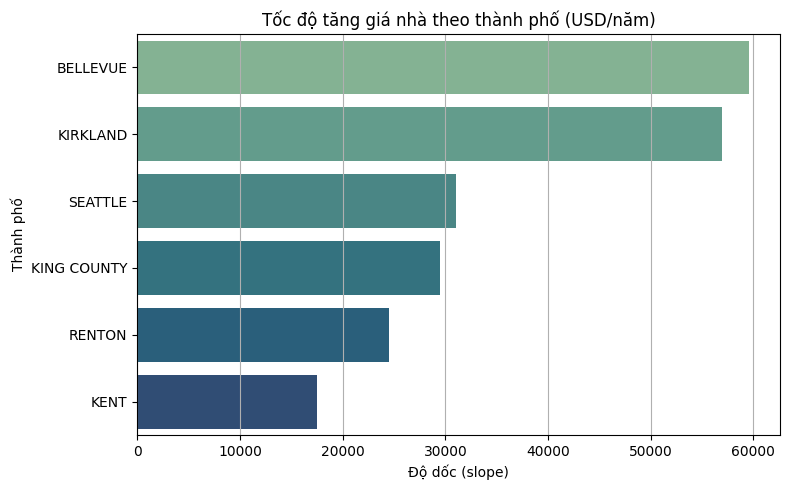

In [41]:
# Tính slope (tốc độ tăng giá) cho từng thành phố
slopes = {}
for city in top_cities:
    sub_df = grouped_city[grouped_city['city'] == city]
    if len(sub_df) >= 2:
        slope, _, _, _, _ = linregress(sub_df['sale_year'], sub_df['sale_price'])
        slopes[city] = slope

# Chuyển sang Series và sắp xếp
slope_series = pd.Series(slopes).sort_values(ascending=False)

# Vẽ biểu đồ barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=slope_series.values, y=slope_series.index, hue=slope_series.index, palette='crest')
plt.title("Tốc độ tăng giá nhà theo thành phố (USD/năm)")
plt.xlabel("Độ dốc (slope)")
plt.ylabel("Thành phố")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

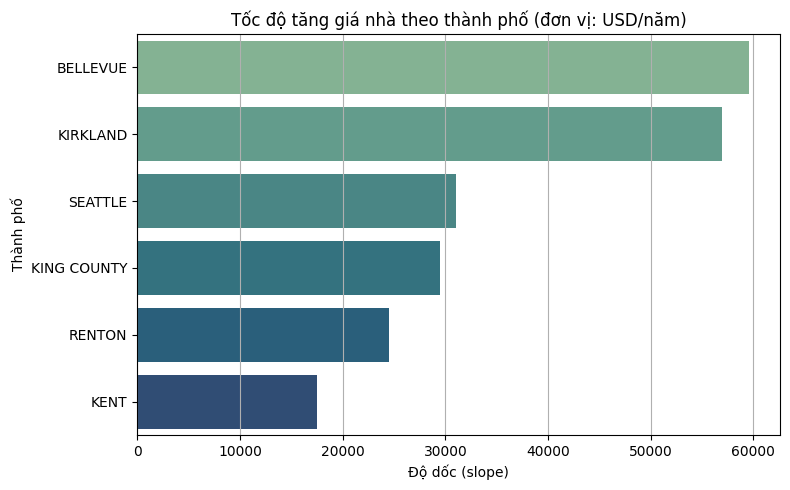

In [42]:
# Tính slope (tốc độ tăng giá) cho từng city
slopes = {}
for city in top_cities:
    sub_df = grouped_city[grouped_city['city'] == city]
    if len(sub_df) >= 2:
        slope, _, _, _, _ = linregress(sub_df['sale_year'], sub_df['sale_price'])
        slopes[city] = slope

# Vẽ biểu đồ barplot
slope_series = pd.Series(slopes).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=slope_series.values, y=slope_series.index, hue=slope_series.index, palette='crest')
plt.title("Tốc độ tăng giá nhà theo thành phố (đơn vị: USD/năm)")
plt.xlabel("Độ dốc (slope)")
plt.ylabel("Thành phố")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

**Nhận xét**

- Độ dốc phản ảnh mức tăng giá trung bình mỗi năm, BELLEVUE có tốc độ tăng giá cao nhất và KENT có tốc độ tăng thấp nhất.

- Điều này khớp với biểu đồ lineplot trước đó và cho thấy rằng sự tăng giá không diễn ra đồng đều.

**KẾT LUẬN**

- Giá nhà không tăng đồng đều ở tất cả các khu vực. Điều này cho thấy yếu tố vị trí địa lý - vị trí thành phố có ảnh hưởng rõ rệt đến xu hướng và tốc độ tăng giá nhà ở.

**Câu hỏi 2:** Tồn tại hiện tượng "hiệu ứng cải tạo" không? Tức là cải tạo càng gần thời gian bán thì ảnh hưởng đến giá càng mạnh? "Hiệu ứng cải tạo" có phụ thuộc vào chất lượng ban đầu của ngôi nhà không? Liệu những căn nhà có chất lượng kém ban đầu khi được cải tạo gần thời gian bán sẽ tăng giá mạnh hơn so với các căn vốn đã có chất lượng tốt?

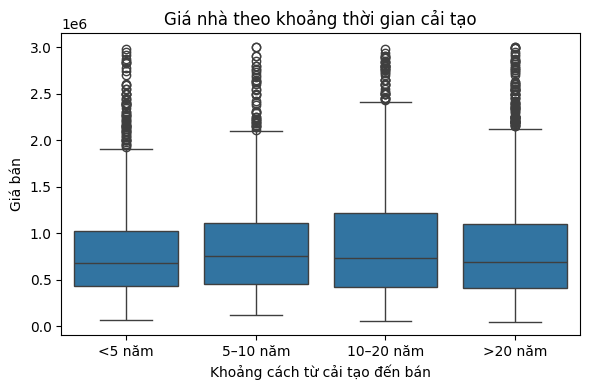

In [43]:
# Xử lý dữ liệu thời gian
df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
df['sale_year'] = df['sale_date'].dt.year
df['years_since_reno'] = df['sale_year'] - df['year_reno']

# Lọc dữ liệu hợp lệ
df_valid = df[(df['years_since_reno'] >= 0) & (df['years_since_reno'] <= 100)].copy()

# Binning khoảng cách cải tạo
bins = [0, 5, 10, 20, 100]
labels = ['<5 năm', '5–10 năm', '10–20 năm', '>20 năm']
df_valid['reno_bin'] = pd.cut(df_valid['years_since_reno'], bins=bins, labels=labels)

# Nhóm grade thành 3 mức chất lượng
def group_grade(x):
    if x <= 5:
        return 'Low'
    elif x <= 8:
        return 'Medium'
    else:
        return 'High'

df_valid['grade_group'] = df_valid['grade'].apply(group_grade)

# === Biểu đồ 1: Boxplot giá theo khoảng cách cải tạo ===
plt.figure(figsize=(6, 4))
sns.boxplot(x='reno_bin', y='sale_price', data=df_valid)
plt.title("Giá nhà theo khoảng thời gian cải tạo")
plt.xlabel("Khoảng cách từ cải tạo đến bán")
plt.ylabel("Giá bán")
plt.tight_layout()
plt.show()

**Nhận xét**

- Các nhóm cải tạo khác nhau đều có phân phối giá tương đối tương đồng nhưng có xu hướng giá tăng nhẹ khi khoảng cách cải tạo trung bình (5-20 năm).

- Tuy nhiên, sự khác biệt không quá rõ ràng do vẫn có nhiều outliers và phân tán giá lớn.

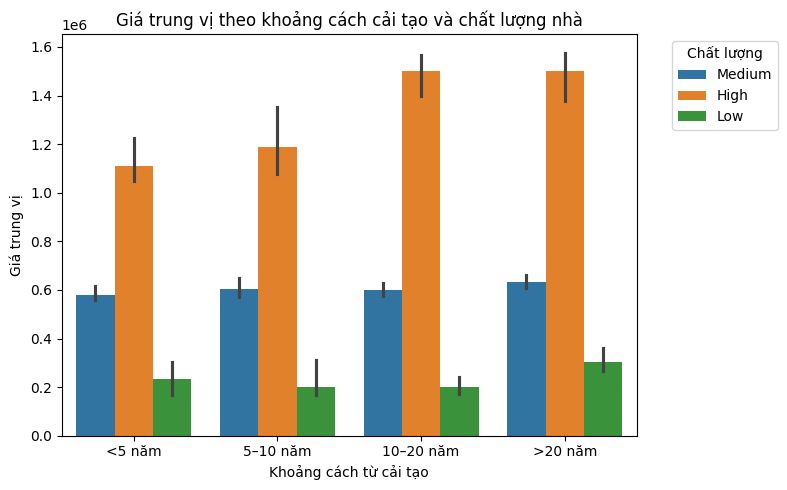

In [44]:
# === Biểu đồ 2: Barplot giá trung vị theo reno_bin và grade_group ===
plt.figure(figsize=(8, 5))
sns.barplot(x='reno_bin', y='sale_price', hue='grade_group', data=df_valid, estimator='median')
plt.title("Giá trung vị theo khoảng cách cải tạo và chất lượng nhà")
plt.xlabel("Khoảng cách từ cải tạo")
plt.ylabel("Giá trung vị")
plt.legend(title='Chất lượng', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Nhận xét**

- Nhóm nhà chất lượng thấp và Medium không có sự chênh lệch rõ rệt giữa các nhóm thời điểm cải tạo.

- Với nhóm nhà chất lượng cao, giá trung vị cao nhất nằm ở khoảng 10-20 năm sau cải tạo nhưng không giảm mạnh sau cải tạo 20 năm.

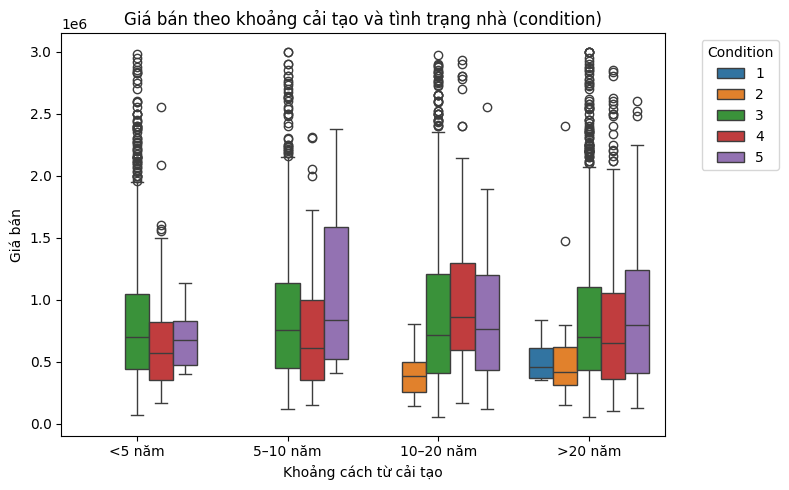

In [45]:
# === Biểu đồ 3: Boxplot theo condition và reno_bin ===
plt.figure(figsize=(8, 5))
sns.boxplot(x='reno_bin', y='sale_price', hue='condition', data=df_valid)
plt.title("Giá bán theo khoảng cải tạo và tình trạng nhà (condition)")
plt.xlabel("Khoảng cách từ cải tạo")
plt.ylabel("Giá bán")
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Nhận xét**

- Nhìn chung, tình trạng nhà càng tốt (condition 4-5) thì giá bán càng cao dù cải tạo đã từ lâu hay mới đây.

- Với condition thấp hơn (1-2), giá thấp hơn hẳn.

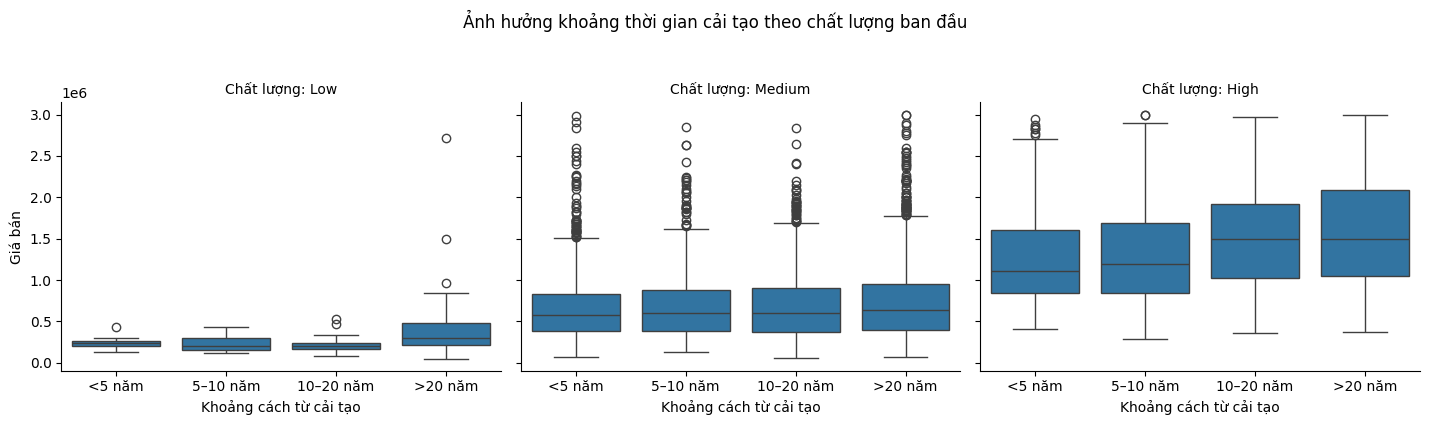

In [46]:
# === Biểu đồ 4: FacetGrid theo grade_group ===
g = sns.FacetGrid(df_valid, col='grade_group', col_order=['Low', 'Medium', 'High'], height=4, aspect=1.2)
g.map_dataframe(sns.boxplot, x='reno_bin', y='sale_price', order=labels)
g.set_axis_labels("Khoảng cách từ cải tạo", "Giá bán")
g.set_titles(col_template="Chất lượng: {col_name}")
g.fig.suptitle("Ảnh hưởng khoảng thời gian cải tạo theo chất lượng ban đầu", y=1.05)
plt.tight_layout()
plt.show()


**Nhận xét**

- Đối với nhóm chất lượng thấp, nhìn chung, giá bán tăng dần khi thời gian cải tạo xa hơn thời điểm bán. Đặc biệt, nhóm ">20 năm" có giá bán cao hơn rõ rệt so với các nhóm còn lại. Điều này ngược lại với giả thuyết rằng cải tạo gần sẽ giúp tăng giá cho nhà chất lượng thấp.

- Đối với nhóm chất lượng trung bình, giá bán có xu hướng tăng nhẹ. Điều này cho thấy nhà trung bình nếu được cải tạo từ lâu vẫn giữ giá tốt hơn so với cải tạo gần thời điểm bán.

- Nhóm chất lượng cao thể hiện xu hướng tăng giá theo thời gian cải tạo rõ ràng nhất. Những căn nhà cải tạo gần đây có giá trị trung vị thấp nhất trong nhóm chất lượng cao và tăng dần theo theo thời gian cải tạo.

Sau khi phân tích ta thấy rằng những căn nhà được cải tạo cách thời điểm bán >10-20 năm, thận chí >20 năm lại có giá bán trung vị cao hơn so với những căn cải tạo gần hơn. Điều này có thể do hiện tượng giá cao không phải do cải tạo sớm hay muộn, mà đơn giản là do thời điểm bán rơi vào giai đoạn giá nhà đang tăng mạnh. Ta tiến hành kiểm chứng giả thuyết này:

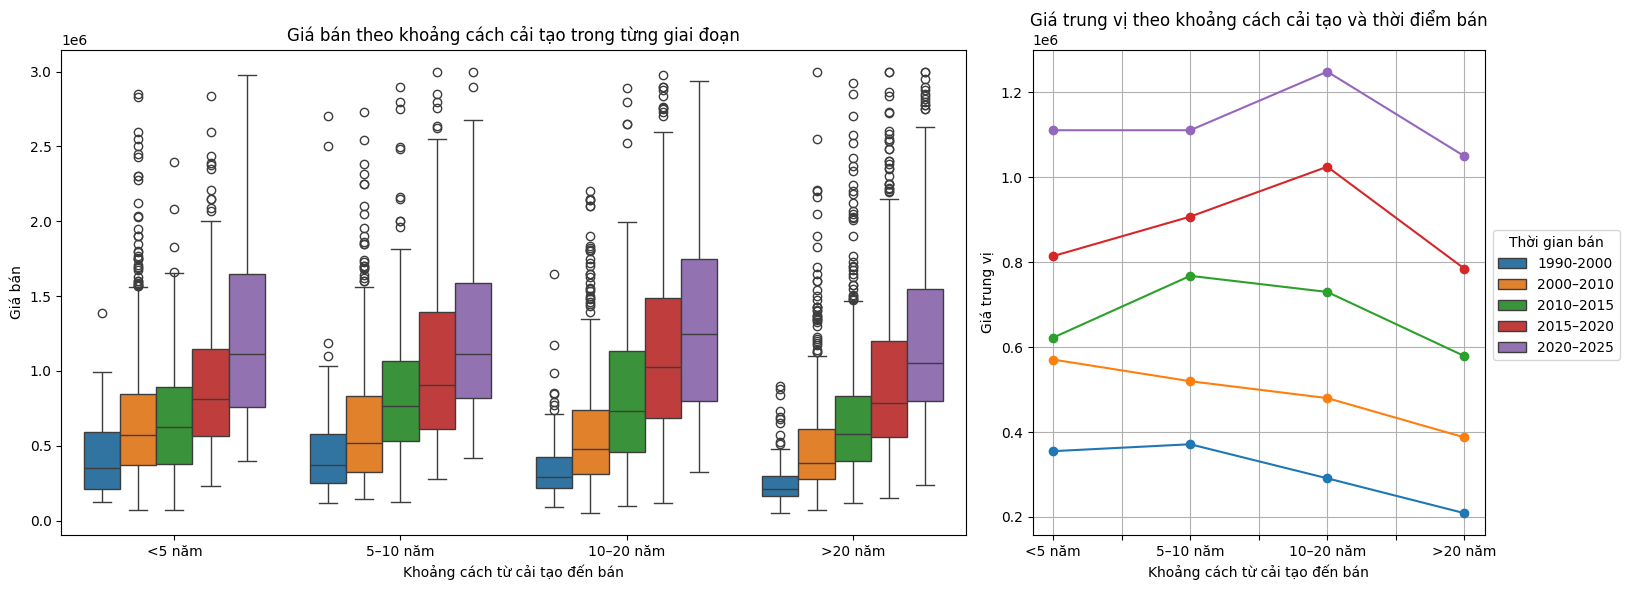

In [47]:
# Nhóm theo thời gian bán
df_valid['sale_period'] = pd.cut(df_valid['sale_year'], 
                                 bins=[1990, 2000, 2010, 2015, 2020, 2025],
                                 labels=['1990-2000', '2000–2010', '2010–2015', '2015–2020', '2020–2025'])

# Tính giá trung vị
median_pivot = df_valid.pivot_table(
    values='sale_price',
    index='reno_bin',
    columns='sale_period',
    aggfunc='median',
    observed=False
)

# Vẽ subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# Biểu đồ boxplot
sns.boxplot(x='reno_bin', y='sale_price', hue='sale_period', data=df_valid, ax=axes[0])
axes[0].set_title("Giá bán theo khoảng cách cải tạo trong từng giai đoạn")
axes[0].set_xlabel("Khoảng cách từ cải tạo đến bán")
axes[0].set_ylabel("Giá bán")
axes[0].legend_.remove()  # Ẩn legend riêng

# Biểu đồ lineplot
median_pivot.plot(kind='line', marker='o', ax=axes[1])
axes[1].set_title("Giá trung vị theo khoảng cách cải tạo và thời điểm bán")
axes[1].set_xlabel("Khoảng cách từ cải tạo đến bán")
axes[1].set_ylabel("Giá trung vị")
axes[1].grid(True)
axes[1].legend_.remove()  # Ẩn legend riêng

# Thêm legend chung
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Thời gian bán', loc='center right', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.95, 1])  # chừa chỗ cho legend
plt.show()

**Nhận xét**

- Biểu đồ boxplot (Giá bán theo khoảng cách cải tạo trong từng giai đoạn thời gian): 
    - Trong mỗi nhóm khoảng cách cải tạo, giá bán ở các giai đoạn sau luôn cao hơn các giai đoạn trước.

    - Sự khác biệt về giá giữa các nhóm khoảng cách cải tạo trong cùng một giai đoạn là không lớn.

    - Độ phân tác trong từng nhóm khá lớn nhưng xu hướng chung là giá bán bị chi phối mạnh bởi thời điểm bán hơn là khoảng cách cải tạo.

- Biểu đồ lineplot (Giá  trung vị theo khoảng cách cải tạo và thời điểm bán):

    - Giá trung vị tăng dần theo các thời gian bán, các đường màu phía trên (giai đoạn gần đây) luôn cao hơn các đường phía dưới (giai đoạn cũ) cho thấy giá nhà tăng mạnh theo thời gian.

    - Trong từng iai đoạn, giá trung bị giữa các nhóm khoảng cách cải tạo không có xu hướng nhất quán, có giai đoạn giá cao nhất ở nhóm 1-20 năm, có giai đoạn lại cao nhất ở nhóm <5 năm. Đường giá không tăng đều theo khoảng cách cải tạo mà chủ yếu phụ thuộc vào thời điểm bán.

**KẾT LUẬN**

- Không thấy hiệu ứng cải tạo rõ rệt và giá bán tăng mạnh theo thời gian, do đó, nếu chỉ nhìn vào dữ liệu tổng thể thì có thể nhầm rằng cải tạo xa thời điểm bán thì giá cao hơn nhưng thật chất là do những căn nhà bán ở thời điểm sau luôn có giá cao hơn, bất kể khoảng cách cải tạo.

**Câu hỏi 3:** Loại view nào có tác động mạnh nhất đến giá nhà khi so sánh giữa các mức độ view khác nhau? Mức độ view có tăng thì giá có tăng đều không?

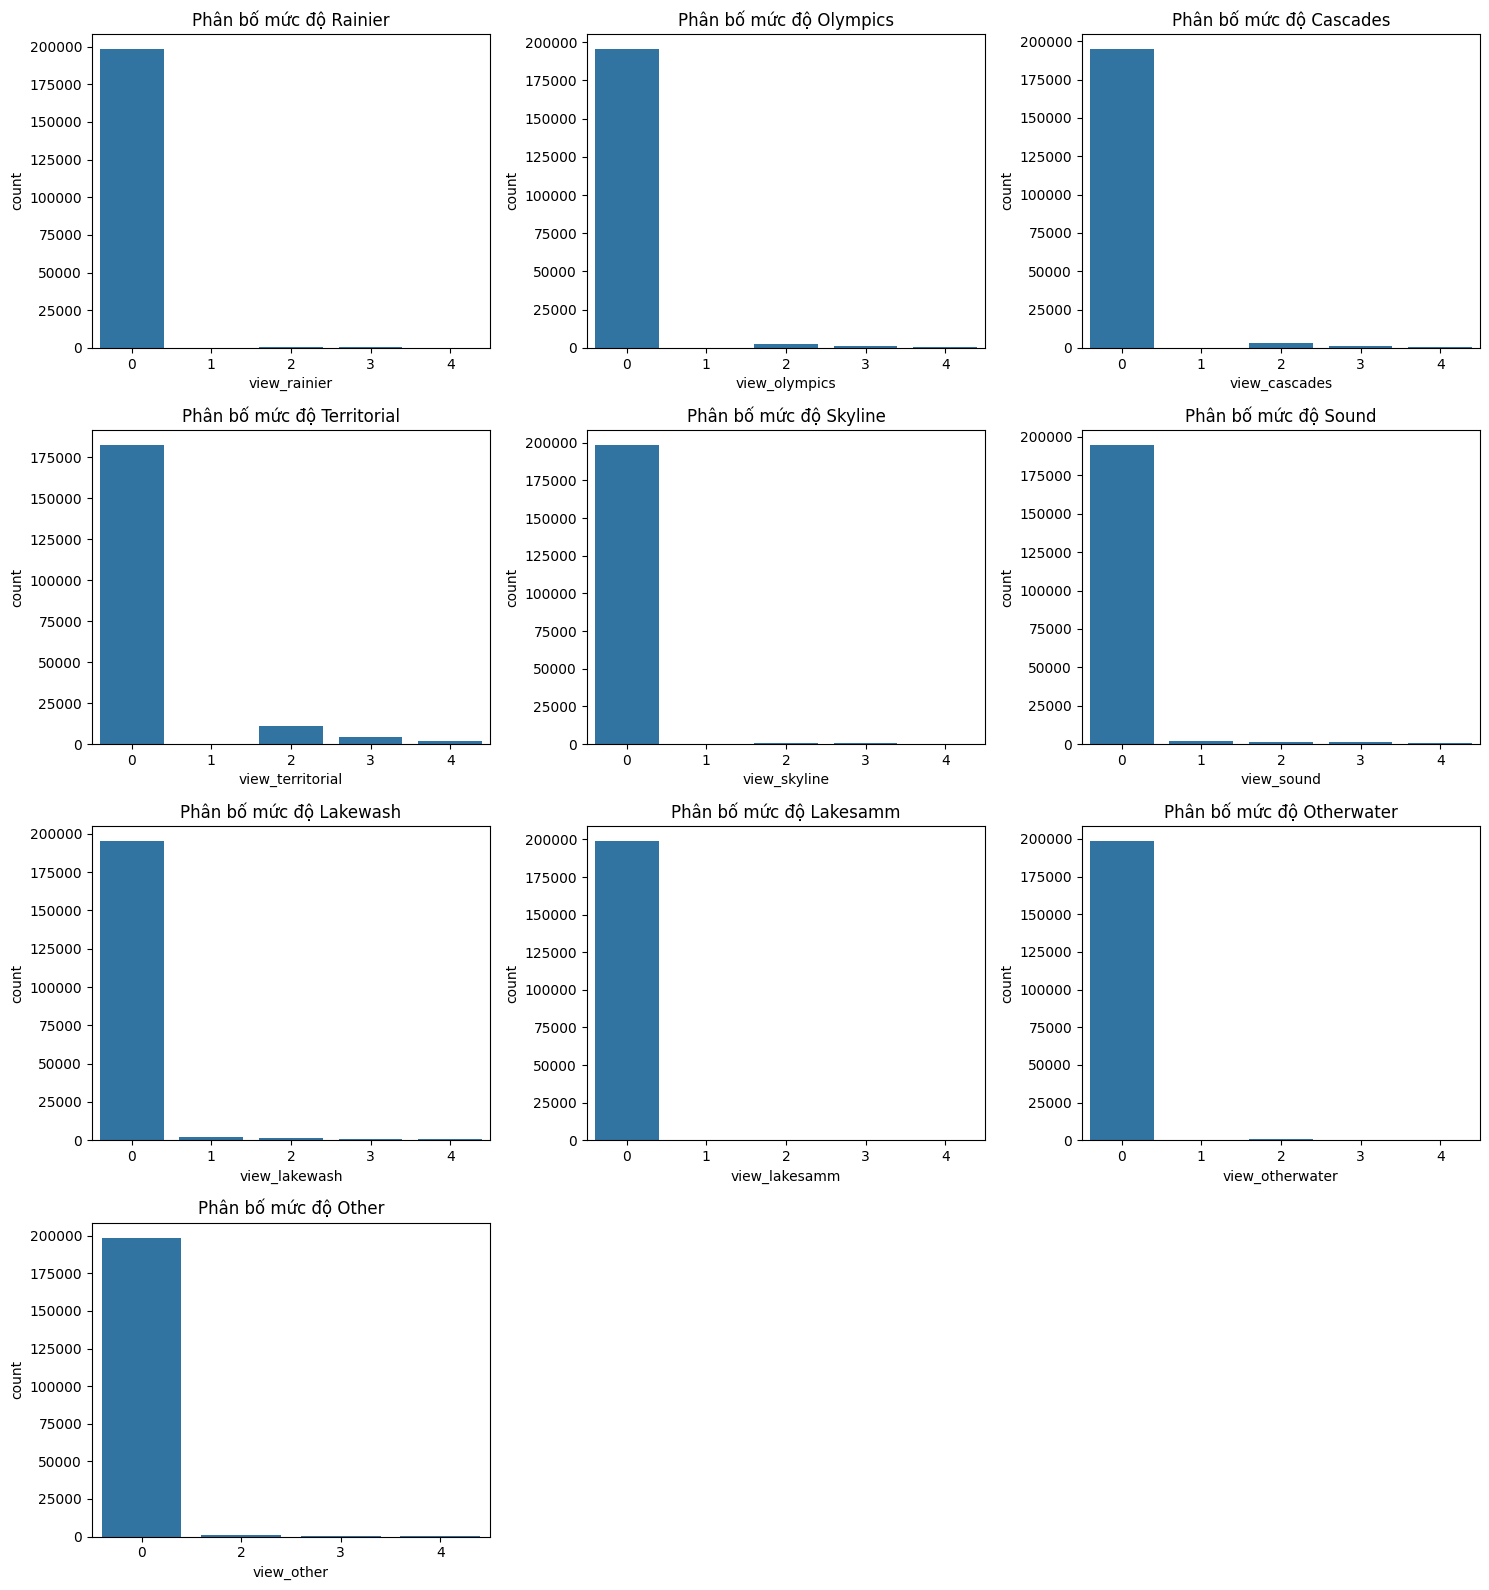

In [48]:
view_cols = [col for col in df.columns if col.startswith('view_')]

ncols = 3
nrows = (len(view_cols) + ncols - 1) // ncols
plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(view_cols):
    plt.subplot(nrows, ncols, i + 1)
    sns.countplot(x=col, data=df, order=sorted(df[col].dropna().unique()))
    plt.title(f'Phân bố mức độ {col.replace("view_", "").title()}')

plt.tight_layout()
plt.show()


**Nhận xét**

- Gần như tất cả các loại view đều thiên lệch rất mạnh về mức 0, tức là đa phần nhà không có view đặc biệt.

- Những mức cao (1-4) xuất hiện rất ít, cho thấy nhà có view đẹp là hiếm.

/tmp/ipykernel_21516/2576265411.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['sale_price'].median()


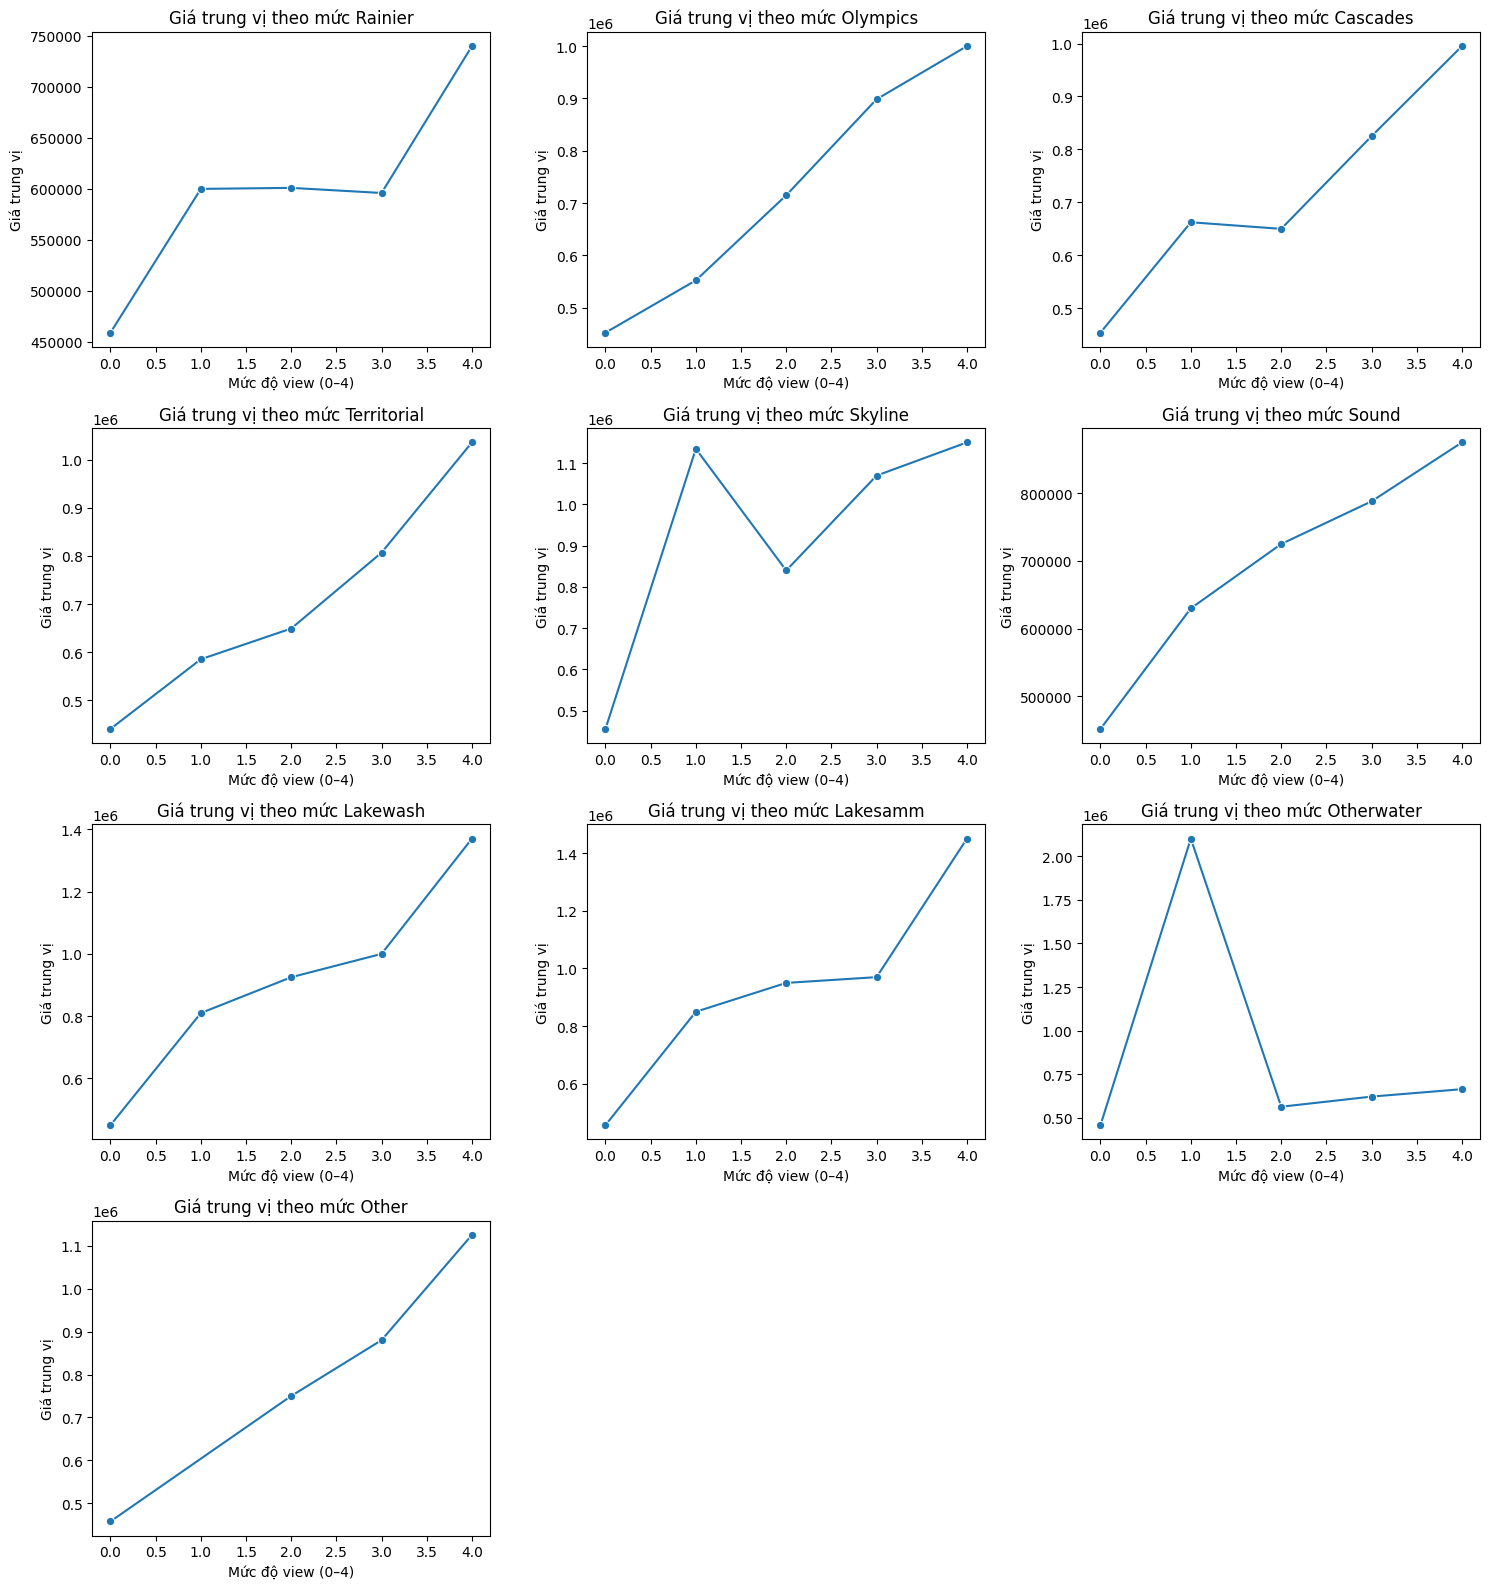

In [49]:
view_price_stats = {}

for col in view_cols:
    temp = df.groupby(col)['sale_price'].median()
    view_price_stats[col] = temp

# Vẽ
ncols = 3
nrows = (len(view_cols) + ncols - 1) // ncols
plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(view_cols):
    plt.subplot(nrows, ncols, i + 1)
    df_group = view_price_stats[col]
    sns.lineplot(x=df_group.index, y=df_group.values, marker='o')
    plt.title(f'Giá trung vị theo mức {col.replace("view_", "").title()}')
    plt.xlabel('Mức độ view (0–4)')
    plt.ylabel('Giá trung vị')

plt.tight_layout()
plt.show()

**Nhận xét**

- Hầu hết các loại view cho thấy xu hướng tăng giá theo mức độ view, đặc biệt là view_olympics, view_lakewash, view_lakesamm, view_skyline: mức view càng cao thì giá trị trung bị tăng rõ rệt.

- Một vài view như view_otherwater, view_skyline có xu hướng không ổn định do ít dữ liệu ở các mức cao.

- view_rainer, view_cascades, view_lakewash có xu hướng tăng nhưng không đồng đều.

/tmp/ipykernel_21516/3360517620.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(col)['sale_price'].median()


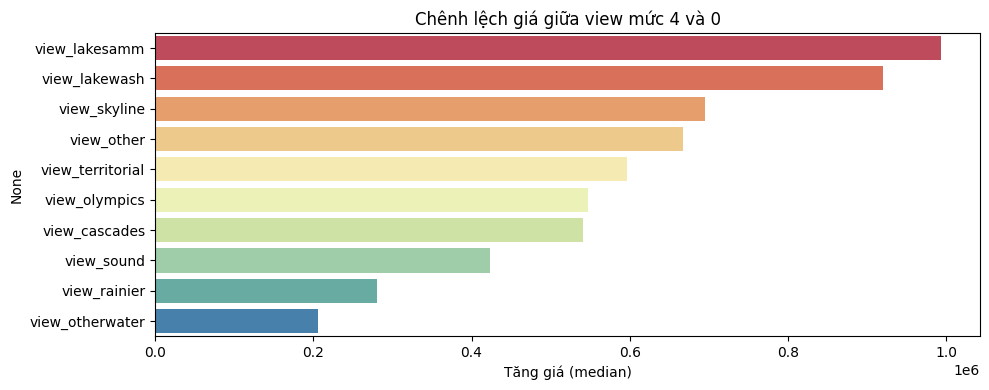

In [50]:
view_diffs = {}

for col in view_cols:
    stats = df.groupby(col)['sale_price'].median()
    if 0 in stats.index and 4 in stats.index:
        view_diffs[col] = stats[4] - stats[0]

view_diffs = pd.Series(view_diffs).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x=view_diffs.values, y=view_diffs.index, hue=view_diffs.index, palette='Spectral')
plt.title("Chênh lệch giá giữa view mức 4 và 0")
plt.xlabel("Tăng giá (median)")
plt.tight_layout()
plt.show()


**Nhận xét**

- Những view có tác động mạnh nhất đến giá nhà: view_lakesamm, view_lakewash, view_skyline, chênh lệch từ 700k đến hơn 1 triệu đô.

- Những view có tác động thấp gồm view_rainier, view_otherwater, view_sound (dưới 500k đô).

**KẾT LUẬN**

- Nhà có view đẹp hiếm thì giá trị cao hơn rất nhiều.

- Mức độ view càng cào, giá nhà càng cao, đặc biệt là các loại view hướng hồ hoặc view hướng thành phố.

- Khi xây dựng mô hình định giá, các biến view nên được giữ lại để giúp cho mô hình học tốt hơn.